### Package Imports

In [1]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

init = time()

### Latexify for LaTeX ready plots

In [2]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.33 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### Loading dataset

In [3]:
california_ozone = pd.read_csv("../../data/cal_o3.csv.gz", index_col = None)

### Choosing data: date between 01/05/90 to 30/09/90 and time between 10 a.m. to 6 p.m.

In [4]:
ca10to6 = california_ozone[(california_ozone['Time Local'] <= '18:00') & (california_ozone['Time Local'] >= '10:00')]
ca10to6 = ca10to6[(ca10to6['Date Local'] >= '1990-05-01') & (ca10to6['Date Local'] <= '1990-09-30')]

### Creating ID

In [5]:
ca10to6['ID'] = ca10to6['County Code'].apply(str)+ca10to6['Site Num'].apply(str)
ca10to6.head(2)

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Date Local,...,MDL,Uncertainty,Qualifier,Method Type,Method Code,Method Name,State Name,County Name,Date of Last Change,ID
2806,6,1,3,44201,1,37.6849,-121.7659,WGS84,Ozone,1990-05-01,...,0.005,NaN,NaN,FEM,19,INSTRUMENTAL - ULTRA VIOLET,California,Alameda,2010-08-20,13
2807,6,1,3,44201,1,37.6849,-121.7659,WGS84,Ozone,1990-05-01,...,0.005,NaN,NaN,FEM,19,INSTRUMENTAL - ULTRA VIOLET,California,Alameda,2010-08-20,13


### Filter and choose if 1) atleast 8/9 observations per day 2) atleast 115 days (75% of 153) data available

In [6]:
mask = ca10to6.groupby(['ID', 'Date Local'])['Sample Measurement'].count() >= 8
ca10to6 = ca10to6.groupby(['ID', 'Date Local']).mean()[mask].reset_index()
ca10to6 = ca10to6[['ID', 'Date Local', 'Latitude', 'Longitude', 'Sample Measurement']]

mask = ca10to6.groupby('ID').count()>=115
ca10to6 = ca10to6.groupby('ID').mean()[mask].dropna()

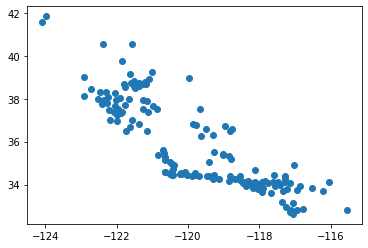

In [7]:
plt.scatter(ca10to6['Longitude'], ca10to6['Latitude']);

## Let us load Los Angeles Centroids for Interpolation

### Before that, let us visualize LA County and nearby regions!

In [8]:
import geopandas as gpd

Venture - 111, Orange - 59, Riverside - 65, San Bernardino - 71, LA - 37

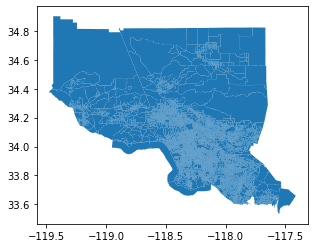

In [9]:
gdf = gpd.read_file("../../data/block_groups/california/tl_2016_06_bg.shp")
gdf = gdf[gdf['COUNTYFP'].isin(['037', '059', '111'])]
gdf['INTPTLAT'] = np.float64(gdf['INTPTLAT'].values)
gdf['INTPTLON'] = np.float64(gdf['INTPTLON'].values)
gdf = gdf[gdf['INTPTLAT']>=33.6]
gdf = gdf[gdf['INTPTLAT']<=35.5]
gdf = gdf[gdf['INTPTLON']>=-119.4]
gdf.plot();

In [10]:
mask1 = gdf['COUNTYFP']=='037'
lagdf = gdf[gdf['COUNTYFP']=='037']

In [11]:
shapes = lagdf['geometry'].unique()
centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
centroids = np.array(centroids)

In [12]:
centroids.shape

(6419, 2)

## We are only interested in LA for Kriging Interpolation of O3
## Accordingly we choose Latitude <= 34.81

In [13]:
ca10to6 = ca10to6[ca10to6['Latitude']<=34.81]

## Let us interpolate over LA County!

In [14]:
X = ca10to6[['Longitude', 'Latitude']].values
y = ca10to6[['Sample Measurement']].values.ravel() * 1000

### Kriging Interpolation

In [15]:
from polire import Kriging
## PyKrige takes Longitude Values in the Range 0 to 360 => Add 360 to our values!
X_krig = X.copy()
X_test_krig = centroids.copy()
# X_krig[:, 0] = X_krig[:, 0] + 360
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X_krig, y)

X_test_krig[:, 0] = X_test_krig[:, 0] + 360
krig_predictions = krig.predict(X_test_krig)

### Spatial Average

In [16]:
from polire import SpatialAverage
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)
spatial_predictions = spatial.predict(centroids)

### IDW

For IDW, the authors choose a 250 km radius. Let us likewise choose our training points and use the IDW Class repeatedly.

polire supports geographic coordinates and hence we have that distance too!

In [17]:
from polire import IDW
from polire.utils.distance import haversine, euclidean
idw = IDW(coordinate_type='Geographic', exponent=1)
idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(np.array(data_point).reshape(1,2), X).ravel()
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    idw.fit(X_train, y_train)
    idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

### $k$-NN, with $k = 1$.

In [18]:
from polire.custom import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor
knn = CustomInterpolator(KNeighborsRegressor(n_neighbors=1))
knn.fit(X, y)
knn_predictions = knn.predict(centroids)

In [19]:
krig_predictions = np.array(krig_predictions).reshape(-1,1)

In [20]:
spatial_predictions = np.array(spatial_predictions).reshape(-1,1)

In [21]:
idw_predictions = np.array(idw_predictions).reshape(-1,1)

In [22]:
gdf_krig_predictions = []
gdf_knn_predictions = []
gdf_idw_predictions = []
gdf_spav_predictions = []

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_krig_predictions.append(krig_predictions[ix][0])
        ix = ix + 1
    else:
        gdf_krig_predictions.append(np.nan)

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_spav_predictions.append(spatial_predictions[ix])
        ix = ix + 1
    else:
        gdf_spav_predictions.append(np.nan)

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_idw_predictions.append(idw_predictions[ix][0])
        ix = ix + 1
    else:
        gdf_idw_predictions.append(np.nan)

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_knn_predictions.append(knn_predictions[ix])
        ix = ix + 1
    else:
        gdf_knn_predictions.append(np.nan)


In [23]:
polygon = gdf.geometry.unary_union
gdf2 = gpd.GeoDataFrame(geometry=[polygon], crs=gdf.crs)

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [25]:
gdf['Kriging'] = gdf_krig_predictions
gdf['IDW'] = gdf_idw_predictions
gdf['Spatial'] = gdf_spav_predictions
gdf['KNN'] = gdf_knn_predictions

In [26]:
temp = []
for i in gdf_spav_predictions:
    try:
        j = i[0]
        temp.append(j)
    except:
        temp.append(i)

In [27]:
gdf['Spatial'] = temp

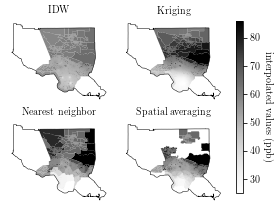

In [31]:
latexify(3.33, 3)
fig, ax = plt.subplots(2,2)

ax[0, 0].set_title("IDW")
gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 0.5, ax=ax[0][0])
gdf.plot(column='IDW', legend=False, ax = ax[0][0], cmap='Greys')
ax[0, 0].axis('Off')

ax[0, 1].set_title("Kriging")
gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 0.5, ax=ax[0, 1])
gdf.plot(column='Kriging', legend=False, ax = ax[0,1], cmap='Greys')
ax[0, 1].axis('Off')

ax[1, 0].set_title("Nearest neighbor")
gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 0.5, ax=ax[1, 0])
gdf.plot(column='KNN', legend=False, ax=ax[1, 0], cmap='Greys')
ax[1,0].axis('Off')

ax[1, 1].set_title("Spatial averaging")

gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 0.5, ax=ax[1, 1])
gdf.plot(column='Spatial', legend=False, ax=ax[1, 1], cmap='Greys')

ax[1,1].axis('Off')

vmin = 25
vmax =86
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = matplotlib.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
cbr = fig.colorbar(sm, cax=cax, cmap='Greys')
cbr.ax.set_ylabel('interpolated values (ppb)', rotation=270, labelpad=13)
# cbr.ax.tick_params(labelsize=60)

plt.tight_layout()
plt.savefig('../../figures/LA-O3.pdf', bbox_extra_artirsts=(cbr,), bbox_inches='tight');

In [29]:
print('Finished in', (time()-init)/60, 'minutes')

Finished in 0.7705044746398926 minutes
